In [23]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import sys
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=2.5, style="whitegrid", rc={
    'figure.figsize':(8,4),
    "lines.linewidth": 3,
    "lines.markersize":20,
    "ps.useafm": True,
    "font.sans-serif": ["Helvetica"],
    "pdf.use14corefonts" : True,
    "text.usetex": True,
    })

note2id = {'Nursing/other': 900001, 'Physician': 900002, 'Nutrition': 900003, 'General': 900004, 'Nursing': 900005, 'Respiratory ': 900006,'Rehab Services': 900007, 'Social Work': 900008, 'Echo': 900010,'ECG': 900011,'Case Management ': 900012,'Pharmacy': 900013,'Consult': 900014, 'Radiology': 900015, 'Discharge summary': 900016}
sentences_len = [1,5,10,20,50]
sentences_len = [100,300,500,800,1000,2000]
hs = ['longest', 'countmedicalsent', 'fracmedicalsent'] #, 'fracmedicalsent'
#hs = ['longest', 'countmedicalsent', 'similaritymix_0.2_max','similaritymix_0.2_max_norm']
hs = [h+"_token" for h in hs]
#hs = ['longest','similaritymix_0.2', 'similaritymix_0.4', 'similaritymix_0.6', 'similaritymix_0.8', 'similarity_near', 'similarity_far'] #, 'fracmedical'
model_mapping = {"DAN":"DeepAverageNetwork", "LR":"logistic_regression"}
line_sty = {"LR":"-", "DAN":"--"}


DATA_DIR = "/data/test_mimic_output/"

BASE_DIR = "/home/joe/value-of-medical-notes/"

In [24]:
def name_mapping(s):
    sim = 'sim' in s
    s = s.replace("_token", "")
    s = s.replace("_percent", "")
    mapping = {'countmedicalsent':'count', 'fracmedicalsent':'frac', 'fracmedicalsent_norm':'frac-n',
              }

    s = s.replace("_sim", "")
    s = s.replace("_test", "")
    s = s.replace("_new", "")
    s = s.replace("_norm", "-n")
    if not sim:
        return mapping.get(s, s)
    sim_covert = {'similarity_far':'dis', 'similarity_near':'sim', 'similaritymix':"mix",'countmedicalsent':'count', 'fracmedicalsent':'frac', 'fracmedicalsent_norm':'frac-n'}
    for k,v in sim_covert.items():
        if k in s:
            s=s.replace(k,v)
            break
    #print(s.replace("_", '-'))
    return s.replace("_", '-')

In [25]:
def get_results(task, model, note, period, feature_used, heuristics, metric, q, f=None):
    model_name = note +'_'+ period + '.csv'
    if feature_used == "all":
        model_name = "feature_text_" + model_name
    elif feature_used == "all_but_notes":
        model_name = "feature_" + model_name
    else:
        model_name = "text_" + model_name
    if f:
        model_name = f + "_" + model_name
    df = pd.read_csv(f'{DATA_DIR}/select_sentence/{model}/group/{q}/{task}/{heuristics}/{model_name}')
#     print(f'/home/joe/physician_notes/models/sentence_select/results/{model}/{task}/{heuristics}/{model_name}')
#     print(df.columns)
#     if q == "q1":
#         print(f"{model}/group/{q}/{task}/{heuristics}/{model_name}")
#         print(df)
    return df[metric].iloc[0]

In [26]:
def get_number(task, model, note, period, feature_used, heuristics, metric, q, f=None):
    model_name = note +'_'+ period + '.csv'
    if feature_used == "all":
        model_name = "feature_text_" + model_name
    elif feature_used == "all_but_notes":
        model_name = "feature_" + model_name
    else:
        model_name = "text_" + model_name
    if f:
        model_name = f + "_" + model_name
    df = pd.read_csv(f'{DATA_DIR}/select_sentence/{model}/group/{q}/{task}/{heuristics}/{model_name}')
#     print(f'/home/joe/physician_notes/models/sentence_select/results/{model}/{task}/{heuristics}/{model_name}')
#     print(df.columns)
#     if q == "q1":
#         print(f"{model}/group/{q}/{task}/{heuristics}/{model_name}")
#         print(df)
    return df["NUM_ADMIT"].iloc[0]

In [27]:
def get_section_results(task, model, note, period, feature_used, heuristics, metric, q, f=None):
    model_name = note +'_'+ period + '.csv'
    if feature_used == "all":
        model_name = "feature_text_" + model_name
    elif feature_used == "all_but_notes":
        model_name = "feature_" + model_name
    else:
        model_name = "text_" + model_name
    if f:
        model_name = f + "_" + model_name
    print(f'{DATA_DIR}/select_sentence/{model}/group/{q}/{task}/{heuristics}/{model_name}')
    df = pd.read_csv(f'{DATA_DIR}/select_sentence/{model}/group/{q}/{task}/{heuristics}/{model_name}')
#     df = pd.read_csv(f'{BASE_DIR}/models/sentence_select/results/{model}/{task}/{heuristics}/{model_name}')
#     print(f'/home/joe/physician_notes/models/sentence_select/results/{model}/{task}/{heuristics}/{model_name}')
#     print(df.columns)
    return df[metric].iloc[0]

In [28]:
def get_origin_results(task, model, note, period, feature_used, metric,q, f=None):
    model_name =  note +'_'+ period + '.csv'
    if feature_used == "all":
        model_name = "feature_text_" + model_name
    elif feature_used == "all_but_notes":
        model_name = "feature_" + model_name
    else:
        model_name = "text_" + model_name
#     if f:
#         model_name = f + "_" + model_name
    df = pd.read_csv(f'{DATA_DIR}/select_sentence/{model}/group/{q}/{task}/all/{model_name}')
    df = df[df['TYPE']=="test"]

    return df[metric].iloc[0]

In [29]:
def grouped_plot_single(task, model, note, period, feature_used, metric, sentences_len, q,save_dir, unit="sentence", f=None):
    fig, ax = plt.subplots(figsize=(12,7.5))
    is_sim = "sim" in hs[0]
    s_len = []
    h_s = []
    v_s = []
    for sLen in sentences_len:
        for h in hs:
            if h[:10] == 'similarity' and not (note == 'all' or note == 'all_but_discharge'):
                continue
            value = get_results(task, model, note, period, feature_used, h+"_"+str(sLen), metric, q, f=f)
            s_len.append(sLen)
            h_s.append(name_mapping(h))
            v_s.append(value)
#     if note =='physician':
#         res = get_section_results(task, model, note, period, feature_used, 'section', metric)
#         for sLen in sentences_len:
#             s_len.append(sLen)
#             h_s.append("section")
#             v_s.append(res)
#     if note =='all_but_discharge' and "sim" in hs[0]:
#         res = get_section_results(task, model, note, period, feature_used, 'section_sim', metric)
#         for sLen in sentences_len:
#             s_len.append(sLen)
#             h_s.append("section_sim".replace("_","-"))
#             v_s.append(res)
#     models = ["LR", "DAN"] if model == "LR" else ["DAN", "LR"]
#     for m in models:
#         origin_result = get_origin_results(task, m, note, period, feature_used, metric)
#         for sLen in sentences_len:
#             s_len.append(sLen)
#             h_s.append(f"{m} all notes")
#             v_s.append(origin_result)



    df = pd.DataFrame({'Sentence Length': s_len,
                   'Heuristics': h_s,
                   'Values': v_s},
                    columns = ['Sentence Length','Heuristics','Values'])
    color_palette = {name_mapping(h):f"C{i}" for i,h in enumerate(df['Heuristics'].unique())}
    color_palette['DAN all notes'] = "grey"
    color_palette['LR all notes'] = "grey"
    filled_markers = ('o','v', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '^', '<')
    ax= sns.lineplot(x='Sentence Length', y='Values', hue='Heuristics', data=df,
                     markers=filled_markers, dashes=False,style="Heuristics", ax=ax, 
                     palette ="muted")
    
    if f =='physician':
        res = get_section_results(task, model, note, period, feature_used, 'section', metric, q, f=f)
        ax= sns.lineplot(x=sentences_len, y=[res]*len(sentences_len), ax=ax, color="c", label='section')

    if note =='all_but_discharge' and "sim" in hs[0] and 'physician' in save_dir:
        res = get_section_results(task, model, note, period, feature_used, 'section_sim', metric, q, f=f)
        ax= sns.lineplot(x=sentences_len, y=[res]*len(sentences_len),ax=ax,color="c", label='section')

#     models = ["LR", "DAN"] if model == "LR" else ["DAN", "LR"]
    models = ["LR", "LR"] if model == "LR" else ["LR", "LR"]
    ds = ['solid','dashed']
    cc = ['peru','grey']
    for m, d,c in zip(models,ds,cc):
#         origin_result = get_origin_results(task, m, note, period, "all", metric)
#         ax= sns.lineplot(x=sentences_len, y=[origin_result]*len(sentences_len), ls=d, ax=ax, color='peru',label=f"{m} N")
        origin_result = get_origin_results(task, m, note, period, feature_used, metric, q, f=f)
        ax= sns.lineplot(x=sentences_len, y=[origin_result]*len(sentences_len), ls=d, ax=ax, color='grey',label=f"{m} all notes")
    
#     if  "sim" in hs[0]:
#         for m, d,c in zip(models,ds,cc):
#             origin_result = get_results(task, m, note, period, feature_used, 'all_sim', metric, q, f=f)
#             ax= sns.lineplot(x=sentences_len, y=[origin_result]*len(sentences_len), ls=d, ax=ax, color='peru',label=f"{m} last note")
    
    ax.set_ylabel(metric)
    #plt.ylim(0, 1)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[1:], labels[1:],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     num_line = len(ax.lines)
#     ax.lines[num_line//2-1].set_linestyle("--")
#     l.get_lines()[-2].set_linestyle("--")
#     ax.lines[-2].set_linestyle("--")
#     l.get_lines()[-3].set_linestyle("--")
#     ax.lines[-3].set_linestyle("--")
    l.get_lines()[-1].set_linestyle("--")
    ax.lines[-1].set_linestyle("--")
    
    num_admit = get_number(task, model, note, period, feature_used, hs[0]+"_"+str(sentences_len[0]), metric, q, f=f)
    
    if unit=="token":
        sen_len = [str(s//100) for s in sentences_len]
        #print(sentences_len)
        ax.set_xlabel("Token Length (hundred)")
        plt.xticks(sentences_len, sen_len)
    if unit=="percent":
        sen_len = [str(s) for s in sentences_len]
        #print(sentences_len)
        ax.set_xlabel("Percentage of total token length (\\%)")
        plt.xticks(sentences_len, sen_len)
    else:
        plt.xticks(sentences_len)
    #ax.set_xticks(sentences_len, sen_len)
    #ax.set_title(f'{model} {task} {note.replace("_","-")} {period}')
    ax.set_title(f'{q} {note.replace("_","-")} {period}, admit:{num_admit}')
    file_name = "-".join([task, model, note, period, feature_used, metric])
    #plt.tight_layout()
    plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
    import pathlib
    path = f'figure/heuristics/new/{save_dir}/'
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    fig.savefig(os.path.join(f'figure/heuristics/new/{save_dir}/',f'{file_name}.pdf'), bbox_inches = "tight")

# Similarity: percent-based

/data/test_mimic_output//select_sentence/LR/group/q0/mortality/section/physician_text_all_but_discharge_24.csv
/data/test_mimic_output//select_sentence/LR/group/q1/mortality/section/physician_text_all_but_discharge_24.csv
/data/test_mimic_output//select_sentence/LR/group/q2/mortality/section/physician_text_all_but_discharge_24.csv
/data/test_mimic_output//select_sentence/LR/group/q3/mortality/section/physician_text_all_but_discharge_24.csv


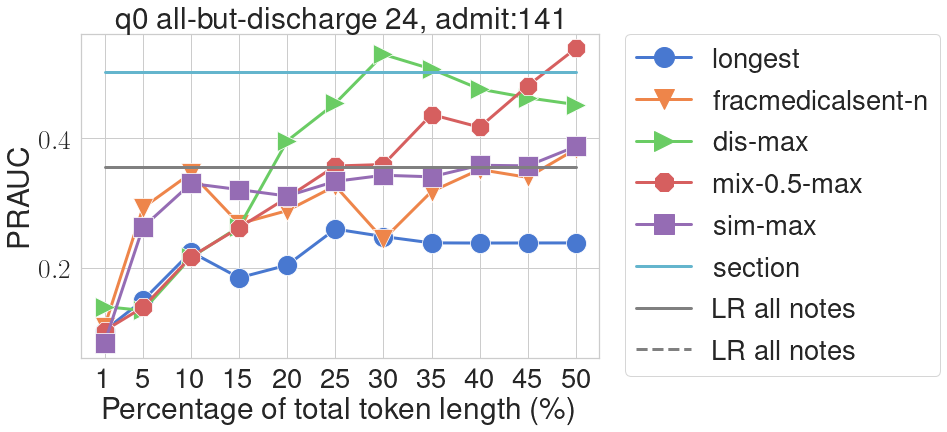

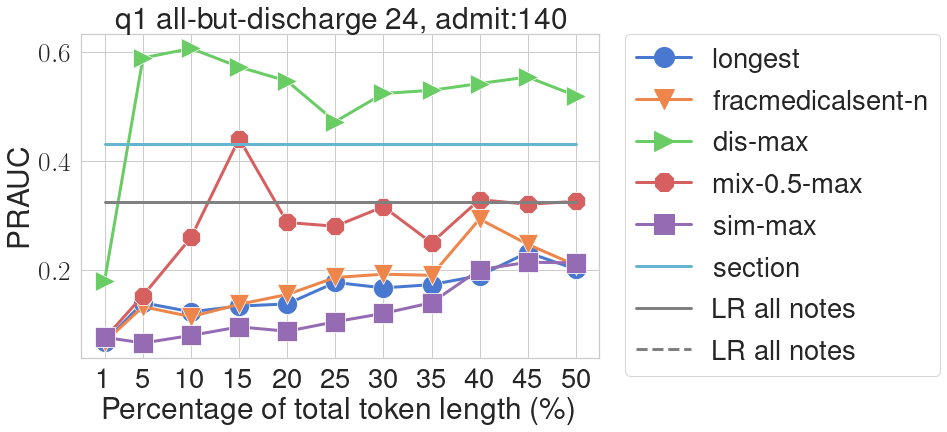

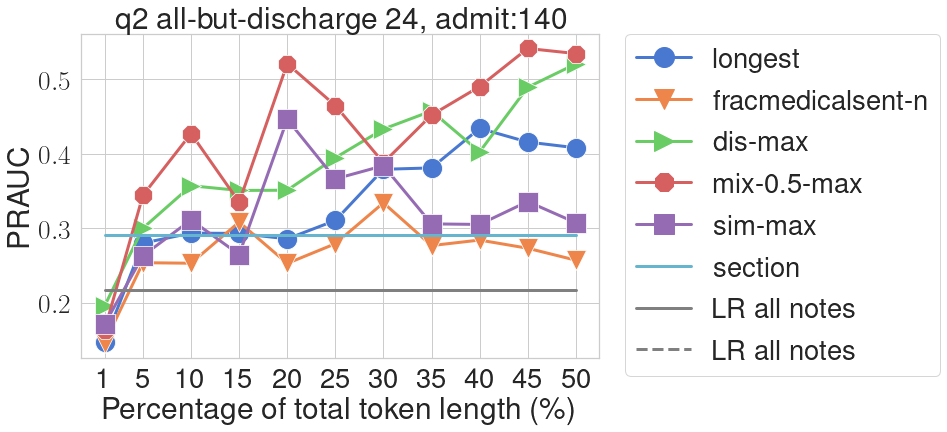

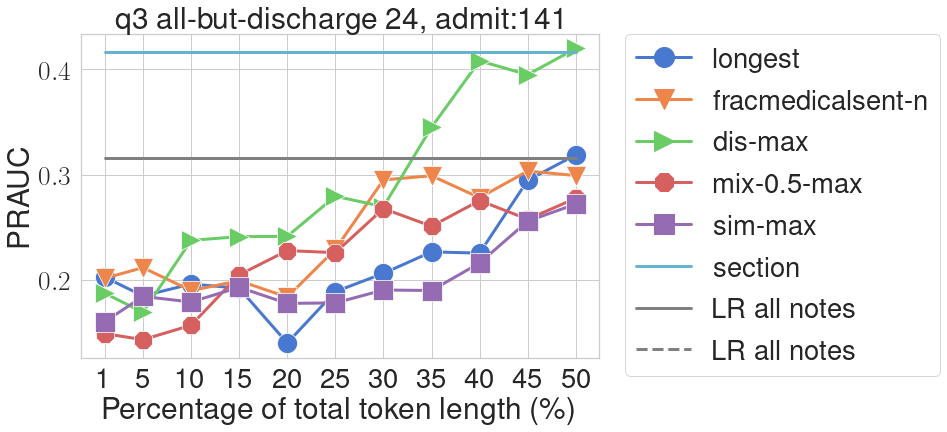

In [30]:
sentences_len = [1,5,10,15,20,25,30,35,40,45,50]
hs_common = ['longest_test','fracmedicalsent_norm_test'] #, 'longest_sim'
setting = "_max_norm"
hs_sim = ['similarity_far', 'similaritymix_0.5' , 'similarity_near'] #'similaritymix_0.5' ,
for sim in ["_max_new_test"]: #,"_max_new_norm_test","_avg_new_test","_avg_new_norm_test"
    hs_sim_tmp = [h+sim for h in hs_sim]
    hs = hs_common + hs_sim_tmp
    hs = [h+"_token_percent" for h in hs]
    for model in ['LR']: # DAM
        for note in [ 'all_but_discharge']:
            for period in ['24']: #, '48', 'retro'
                for metric in ['PRAUC']: #'PRAUC', 'ROCAUC', 'P@1', 'P@5', 'P@10'
                    for q in ["q0","q1","q2","q3"]:
                        grouped_plot_single('mortality', model, note, period, 'notes', metric,sentences_len,q, f'group/{q}/similarity{sim}_physician_percent', 'percent', f='physician')

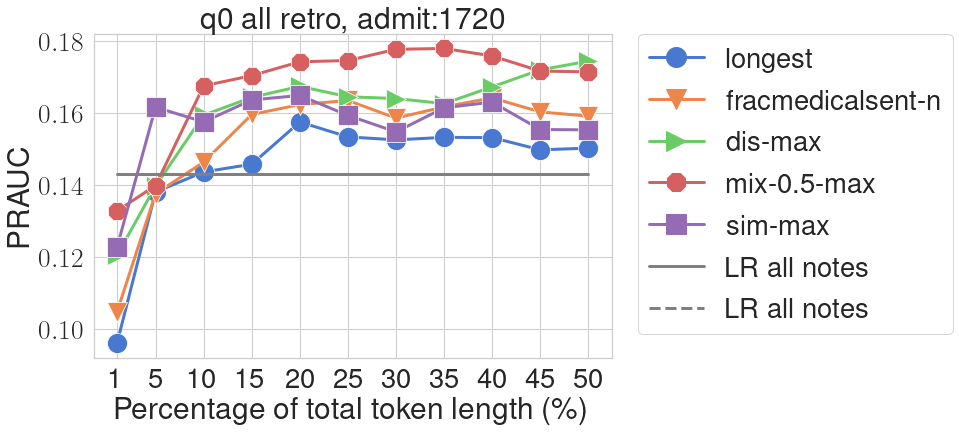

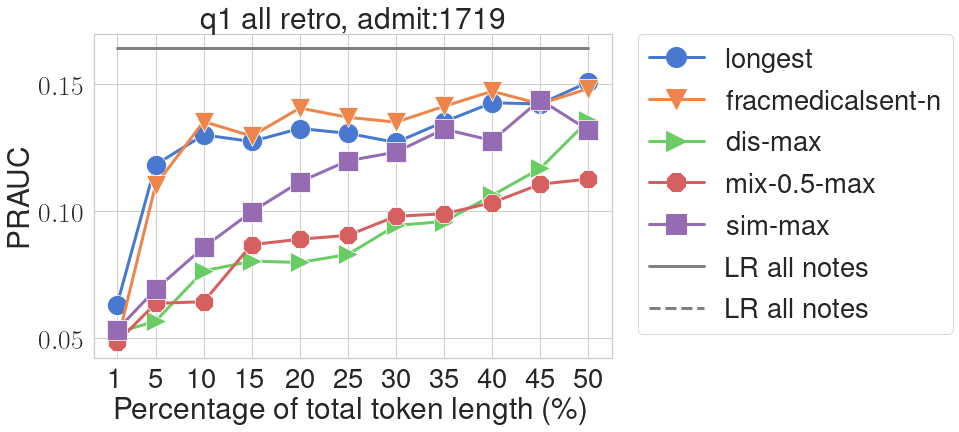

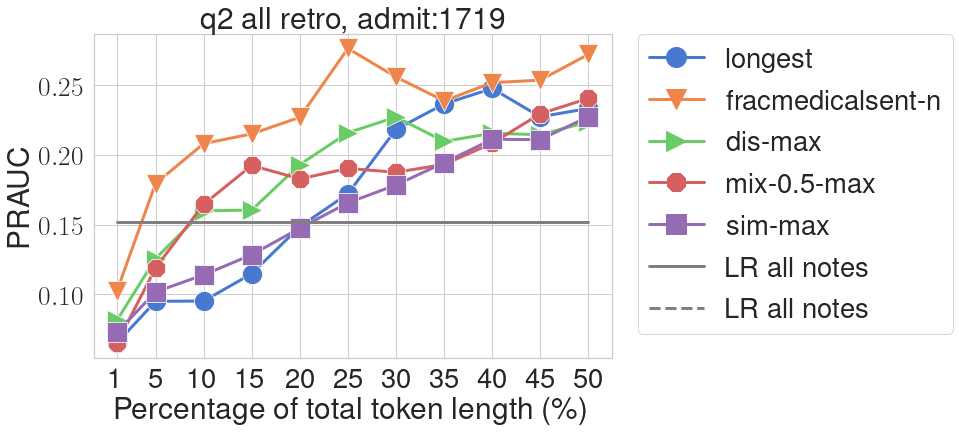

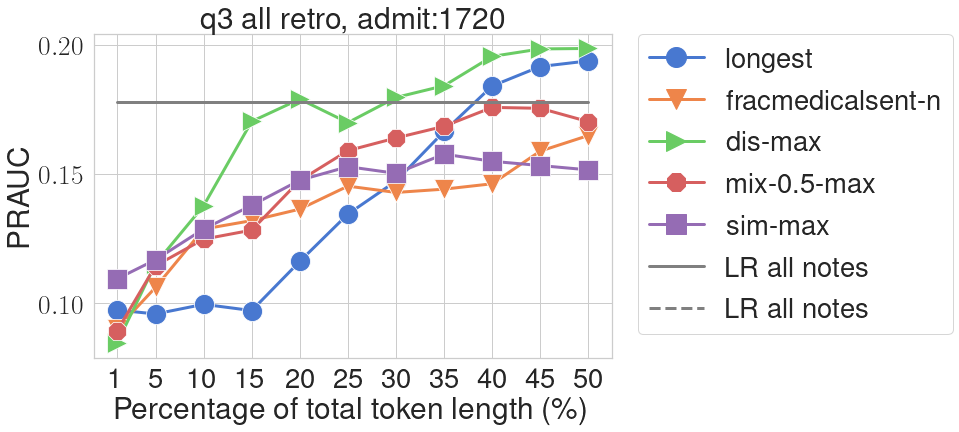

In [31]:
sentences_len = [1,5,10,15,20,25,30,35,40,45,50]
hs_common = ['longest_test','fracmedicalsent_norm_test'] #'longest_test','fracmedicalsent_norm_test','countmedicalsent_sim' , 'longest_sim'
hs_sim = ['similarity_far' , 'similaritymix_0.5', 'similarity_near'] #
for sim in ["_max_new_test"]: #,"_avg" ,"_max_new_norm_test","_avg_new_test","_avg_new_norm_test"
    hs_sim_tmp = [h+sim for h in hs_sim]
    hs = hs_common + hs_sim_tmp
    hs = [h+"_token_percent" for h in hs]
    for model in ['LR']: # DAM
        for note in [ 'all']:
            for period in ['retro']:
                for metric in ['PRAUC']: #'PRAUC', 'ROCAUC', 'P@1', 'P@5', 'P@10'
                    for q in ["q0","q1","q2","q3"]:
                        grouped_plot_single('readmission', model, note, period, 'notes', metric,sentences_len,q, f'group/{q}/similarity{sim}_discharge_percent', 'percent', f='discharge')
#                         grouped_plot_single('readmission', model, note, period, 'notes', metric,sentences_len,q, f'group/{q}/similarity{sim}_discharge_percent', 'percent')